# Importing the libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

#Accessing Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/AABA_2006-01-01_to_2018-01-01 (1).csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,39.69,41.22,38.79,40.91,24232729,AABA
2006-01-04,41.22,41.90,40.77,40.97,20553479,AABA
2006-01-05,40.93,41.73,40.85,41.53,12829610,AABA
2006-01-06,42.88,43.57,42.80,43.21,29422828,AABA
2006-01-09,43.10,43.66,42.82,43.42,16268338,AABA


# Checking for missing values

In [ ]:
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values

# We chose 'High' feature for prices. Let's see what it looks like

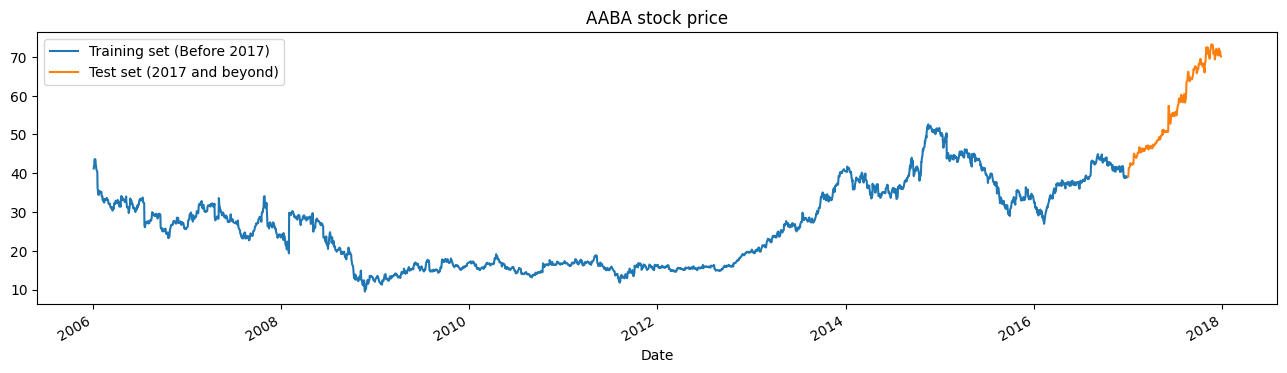

In [ ]:
dataset["High"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('AABA stock price')
plt.show()

# Scaling the training set

In [ ]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [ ]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements
X_train = []
y_train = []
for i in range(60,2768):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping X_train for efficient modelling

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

# The LSTM architecture

In [ ]:
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))


# Compiling the Model

In [ ]:
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=25,batch_size=32)

Epoch 1/25
85/85 [==============================] - 14s 14ms/step - loss: 0.0143
Epoch 2/25
85/85 [==============================] - 1s 12ms/step - loss: 0.0074
Epoch 3/25
85/85 [==============================] - 1s 13ms/step - loss: 0.0062
Epoch 4/25
85/85 [==============================] - 1s 16ms/step - loss: 0.0052
Epoch 5/25
85/85 [==============================] - 2s 18ms/step - loss: 0.0046
Epoch 6/25
85/85 [==============================] - 1s 17ms/step - loss: 0.0038
Epoch 7/25
85/85 [==============================] - 1s 12ms/step - loss: 0.0037
Epoch 8/25
85/85 [==============================] - 1s 12ms/step - loss: 0.0036
Epoch 9/25
85/85 [==============================] - 1s 12ms/step - loss: 0.0032
Epoch 10/25
85/85 [==============================] - 1s 13ms/step - loss: 0.0029
Epoch 11/25
85/85 [==============================] - 1s 13ms/step - loss: 0.0029
Epoch 12/25
85/85 [==============================] - 1s 13ms/step - loss: 0.0028
Epoch 13/25
85/85 [=================

In [ ]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole
# 'High' attribute data for processing
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [ ]:
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
dataset_total

Date
2006-01-03    41.22
2006-01-04    41.90
2006-01-05    41.73
2006-01-06    43.57
2006-01-09    43.66
              ...  
2017-12-22    71.87
2017-12-26    71.39
2017-12-27    70.49
2017-12-28    70.32
2017-12-29    70.13
Name: High, Length: 3019, dtype: float64

# Preparing X_test and predicting the prices

In [ ]:
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

8/8 [==============================] - 1s 8ms/step


#function for visalizing difference or error

In [ ]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real AABA Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('AABA Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('AABA Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

# Visualizing the results for LSTM

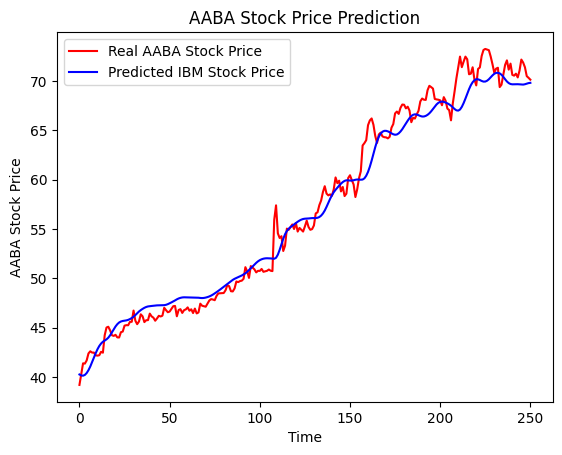

In [ ]:
plot_predictions(test_set,predicted_stock_price)

# Evaluating our model

In [ ]:
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 1.5543678659525653.


In [ ]:
from keras.layers import GRU

#GRU Architecture

In [ ]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))

#Compiling GRU

In [ ]:

regressorGRU.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=25,batch_size=32)

Epoch 1/25
85/85 [==============================] - 8s 13ms/step - loss: 0.0115
Epoch 2/25
85/85 [==============================] - 1s 12ms/step - loss: 0.0062
Epoch 3/25
85/85 [==============================] - 1s 12ms/step - loss: 0.0047
Epoch 4/25
85/85 [==============================] - 1s 12ms/step - loss: 0.0041
Epoch 5/25
85/85 [==============================] - 1s 12ms/step - loss: 0.0037
Epoch 6/25
85/85 [==============================] - 1s 12ms/step - loss: 0.0035
Epoch 7/25
85/85 [==============================] - 1s 15ms/step - loss: 0.0031
Epoch 8/25
85/85 [==============================] - 1s 17ms/step - loss: 0.0030
Epoch 9/25
85/85 [==============================] - 1s 17ms/step - loss: 0.0028
Epoch 10/25
85/85 [==============================] - 1s 12ms/step - loss: 0.0026
Epoch 11/25
85/85 [==============================] - 1s 12ms/step - loss: 0.0026
Epoch 12/25
85/85 [==============================] - 1s 12ms/step - loss: 0.0025
Epoch 13/25
85/85 [==================

# Preparing X_test and predicting the prices

In [ ]:
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

8/8 [==============================] - 1s 7ms/step


# Visualizing the results for GRU

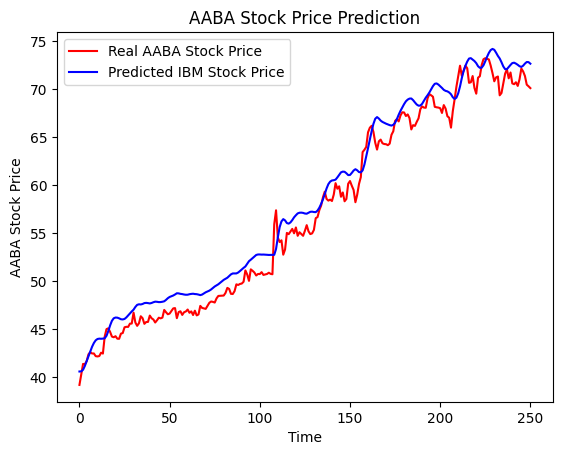

In [ ]:
plot_predictions(test_set,GRU_predicted_stock_price)

# Evaluating GRU

In [ ]:
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 1.7547008356810523.
